In [418]:
import os
import re


import matplotlib.pyplot as plt
import numpy as np
from data_loader import load_all_files, load_latest_iteration

In [419]:
def clean_label(sim_dir):
    """
    Create a short label from a simulation directory path.
    Example: '../data/20250928_145202/vtk_output_hard_1.000000e-02'
             -> 'vtk_output_hard_1e-2'
    """

    if "hard" in sim_dir:
        mode = "Hard"
    else:
        mode = "Soft"

    try:
        m = int(re.search(r"e([+-]?\d+)", sim_dir).group(1))
        return (mode, m, mode + " $\lambda = 10^{" + str(m) + "}$")
    except AttributeError:
        return (mode, -2, sim_dir + "assumed $\lambda = 10^{-2}$")


def load_and_plot(sim_dirs, base_path=""):
    """
    Load multiple simulation directories and produce combined plots.

    Args:
        sim_dirs: list of subdirectories (each containing simulation output)
        base_path: root where simulations are stored
        bin_size: bin width for radial distributions
    """
    particles_dict = {}
    sim_dict = {}

    for sim_dir in sim_dirs:
        print("loading " + sim_dir)

        latest = load_latest_iteration(
            os.path.join(base_path, sim_dir, "data"))
        sim_all = load_all_files(os.path.join(
            base_path, sim_dir, "data"), "simulation")

        particles = latest["particles"]

        # normalize particle columns
        if "lengths_x" in particles:
            particles.rename(columns={"lengths_x": "length"}, inplace=True)
        for drop_col in ["lengths_y", "lengths_z"]:
            if drop_col in particles:
                particles.drop(drop_col, axis=1, inplace=True)

        # use cleaned label
        label = clean_label(sim_dir)
        suffix = ""

        particles = particles.rename(
            columns={
                c: c + suffix for c in particles.columns if c not in ["x", "y", "z"]}
        )
        sim_all = sim_all.rename(
            columns={
                c: c + suffix for c in sim_all.columns if c not in ["simulation_time_s"]}
        )

        particles_dict[label] = particles
        sim_dict[label] = sim_all

    return particles_dict, sim_dict

<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1139187/3737470340.py:15: SyntaxWarning: invalid escape sequence '\l'
  return (mode, m, mode + " $\lambda = 10^{" + str(m) + "}$")
/tmp/ipykernel_1139187/3737470340.py:17: SyntaxWarning: invalid escape sequence '\l'
  return (mode, -2, sim_dir + "assumed $\lambda = 10^{-2}$")


In [420]:
import numpy as np


def pressure_theoretical(r, R, LAMBDA):

    if LAMBDA == 0:
        return (R**2 - r**2)/4

    """
    Analytical solution for radial stress (Weady et al. 2024).
    """
    c = (np.sqrt(1 + LAMBDA * R**2 / 2) - 1) / (2 * LAMBDA * R**2)
    return np.maximum(2 / LAMBDA * np.log(1/(8*c) - c * LAMBDA * r**2), 0)


def spherocylinder_area(length, radius=0.25):
    """
    Calculate projected area of a spherocylinder
    Area = rectangle + 2 semicircles = 2*r*L + π*r²
    """
    return 2 * radius * (length-2*radius) + np.pi * radius**2


def compute_packing_fraction(shell_particles, r_inner, r_outer, mode="soft"):
    """
    Compute packing fraction of particles inside a radial shell.

    Args:
        shell_particles: DataFrame of particles within the shell
        r_inner: inner radius of the shell
        r_outer: outer radius of the shell
        mode: 'soft' or 'hard' (determines which length column to use)

    Returns:
        Packing fraction (float)
    """
    if len(shell_particles) == 0:
        return 0.0

    # Total particle area
    total_particle_area = sum(spherocylinder_area(length)
                              for length in shell_particles["length"])

    # Shell area
    shell_area = np.pi * (r_outer**2 - r_inner**2)

    return total_particle_area / shell_area

In [421]:
# Define colors for modes
MODE_COLORS = {"Hard": "blue", "Soft": "red"}
LINE_STYLES = ["-", "--", "-.", ":"]  # cycle for different exponents


def get_style(mode, exp):
    """
    Returns (color, linestyle) based on sim_dir.
    Hard = blue, Soft = red.
    linestyle determined by exponent.
    """

    # cycle if more than 4 exponents

    linestyle = LINE_STYLES[(-exp) % len(LINE_STYLES)]

    return MODE_COLORS[mode], linestyle


def plot_radial_distribution(particles_dict, variable, bin_size=2.0, outname=None, plot_theory=False):
    """
    Plot radial distribution for multiple simulations.
    Can optionally overlay the theoretical solution for stress.
    """
    fig, ax = plt.subplots(figsize=(8, 5))

    for (mode, exp, label), df in particles_dict.items():
        color, linestyle = get_style(mode, exp)
        df = df.copy()
        df["dist_center"] = np.sqrt(df["x"]**2 + df["y"]**2 + df["z"]**2)
        max_radius = int(df["dist_center"].max())

        r_edges = np.arange(0, max_radius + bin_size, bin_size)
        r_centers = 0.5 * (r_edges[1:] + r_edges[:-1])

        vals = []
        for i in range(len(r_centers)):
            mask = (df["dist_center"] >= r_edges[i]) & (
                df["dist_center"] < r_edges[i+1])
            shell = df[mask]
            if variable == "packing_fraction":
                length_col = [c for c in df.columns if "length" in c][0]
                val = compute_packing_fraction(
                    shell, r_edges[i], r_edges[i+1], length_col)
            else:
                val = shell[variable].mean() if len(shell) else 0
            vals.append(val)

        ax.plot(r_centers, vals, color=color, linestyle=linestyle, label=label)

        # Optional: plot theoretical stress curve
        if plot_theory and "stress" in variable.lower():
            max_radius = int(df["dist_center"].max())

            LAMBDA = 10**exp
            r_theory = np.linspace(0, max_radius+1, 100)
            print(max_radius)
            ax.plot(r_theory, pressure_theoretical(r_theory, max_radius, LAMBDA),
                    label=f"Theory ({label})", color="black", linestyle="--")

    ax.set_xlabel("Radius", fontsize=14)
    ax.set_ylabel(variable.replace("_", " ").title(), fontsize=14)
    ax.set_title(f"Radial Distribution of {variable}", fontsize=14)
    ax.grid(True)
    ax.legend()
    if outname:
        fig.savefig(outname, dpi=300, bbox_inches="tight")
    return fig


def plot_parameter_over_time(sim_dict, x, y, outname=None, rolling=None):
    fig, ax = plt.subplots(figsize=(10, 6))

    for (mode, exp, label), df in sim_dict.items():
        color, linestyle = get_style(mode, exp)
        x_data, y_data = df[x], df[y]
        if rolling:
            x_data = x_data.rolling(window=rolling).mean()
            y_data = y_data.rolling(window=rolling).mean()

        ax.plot(x_data, y_data, color=color, linestyle=linestyle, label=label)

    ax.set_xlabel(x, fontsize=13)
    ax.set_ylabel(y, fontsize=13)
    ax.set_title(f"{y} vs {x}", fontsize=14)
    ax.grid(True)
    ax.legend()
    if outname:
        fig.savefig(outname, dpi=300, bbox_inches="tight")
    return fig

In [422]:
sim_dirs = [
    # "../data/20250928_145202/vtk_output_hard_1.000000e-02/",
    "../data/20250928_145202/vtk_output_soft_1.000000e-02/",
    # "../data/20250928_145202/vtk_output_hard_1.000000e-03/",
    "../data/20250928_145202/vtk_output_soft_1.000000e-03/",
    # "../data/20250928_145202/vtk_output_hard_1.000000e-04/",
    "../data/20250928_145202/vtk_output_soft_1.000000e-04/",
    # "../code/cpp/build/src/vtk_output_hard",
]
particles_dict, sim_dict = load_and_plot(sim_dirs)

loading ../data/20250928_145202/vtk_output_soft_1.000000e-02/
loading ../data/20250928_145202/vtk_output_soft_1.000000e-03/
loading ../data/20250928_145202/vtk_output_soft_1.000000e-04/


In [423]:
particles_dict.keys()

dict_keys([('Soft', -2, 'Soft $\\lambda = 10^{-2}$'), ('Soft', -3, 'Soft $\\lambda = 10^{-3}$'), ('Soft', -4, 'Soft $\\lambda = 10^{-4}$')])

98
99
97


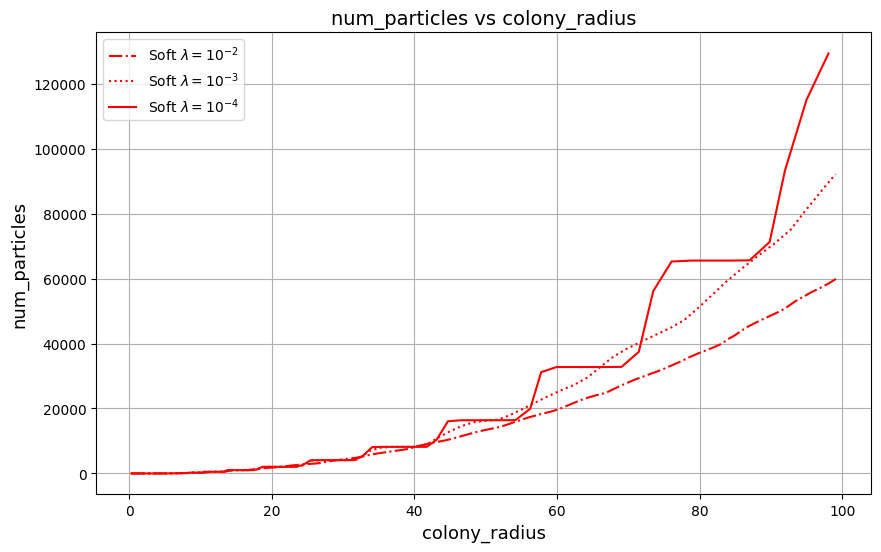

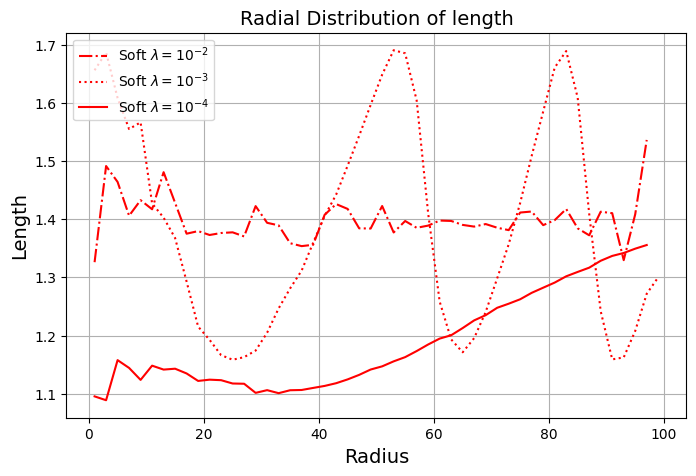

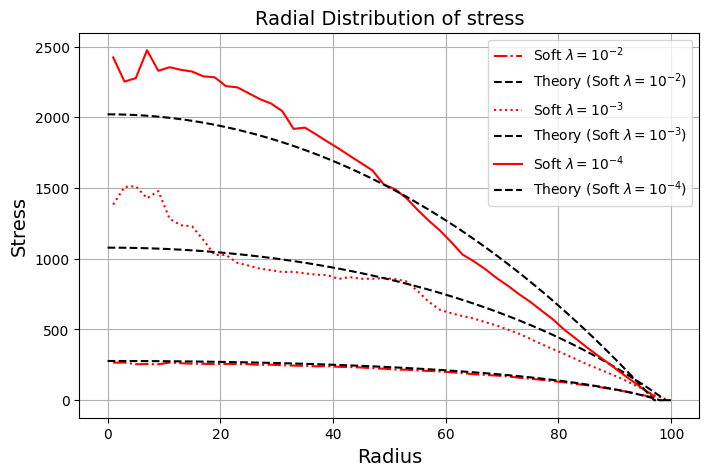

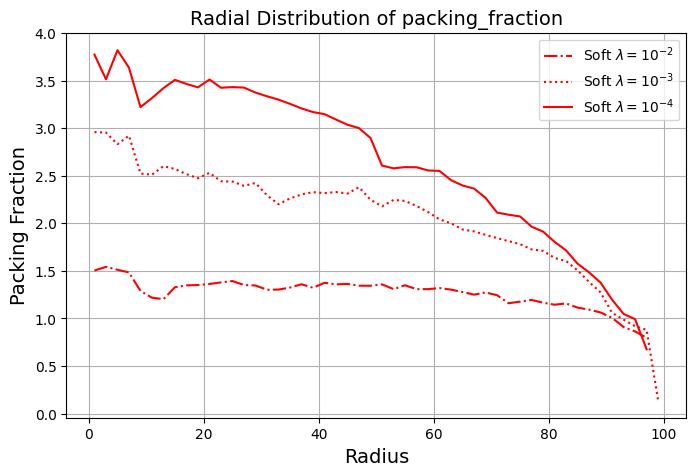

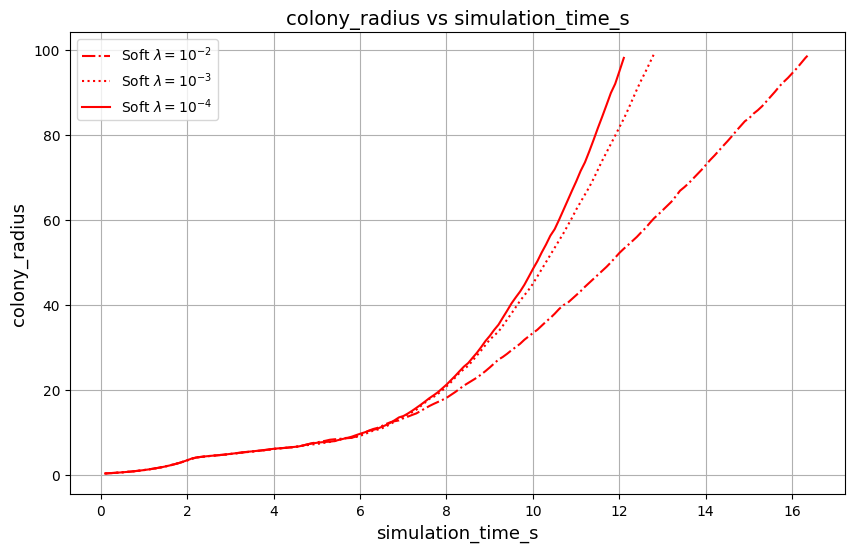

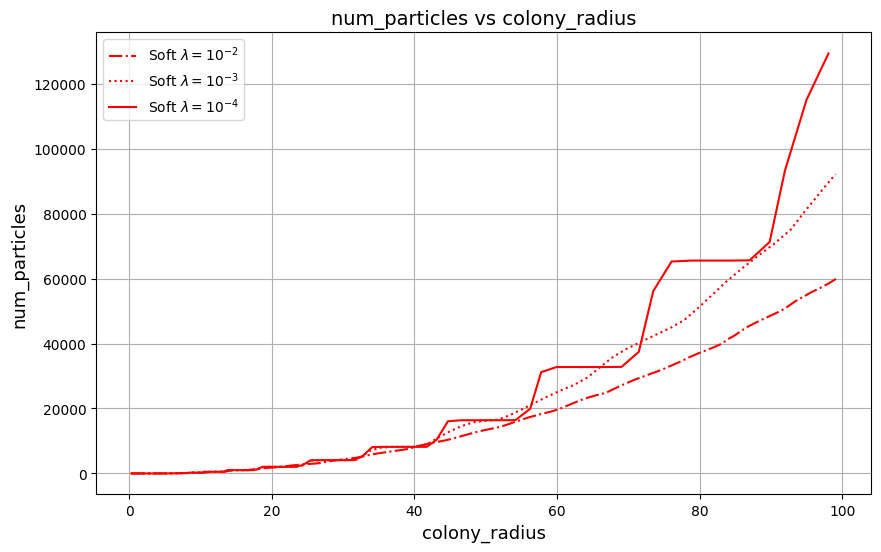

In [424]:

bin_size = 2.0

# Example combined plots
plot_radial_distribution(particles_dict, "length",
                         bin_size, outname="combined_length.png")
plot_radial_distribution(particles_dict, "stress",
                         bin_size, outname="combined_stress.png", plot_theory=True)
plot_radial_distribution(
    particles_dict, "packing_fraction", bin_size, outname="combined_packing.png")
plot_parameter_over_time(sim_dict, "simulation_time_s",
                         "colony_radius", outname="combined_colony_radius.png")
plot_parameter_over_time(sim_dict, "colony_radius",
                         "num_particles", outname="combined_growth.png")